# Model training 
Summary:
- Based on generated feature, I build logistic regression, random forest, GBDT and neural network to predict monthly retention behavior.
- Random forest shows best performance
- Use grid-search to fine tuning random forest
- The recency feature is the most important one.

### 1. Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

% matplotlib inline
# Always make it pretty.
plt.style.use('ggplot')

In [2]:
# Load data from file
df = pd.read_csv('../data/df_model_final.csv')

In [3]:
# Browse dataset
df.head(5)

,uid,label,freq_P_last_1,freq_P_last_3,freq_P_last_7,freq_P_last_14,freq_P_last_30,freq_D_last_1,freq_D_last_3,freq_D_last_7,...,freq_D_last_30,freq_S_last_1,freq_S_last_3,freq_S_last_7,freq_S_last_14,freq_S_last_30,recency,device,total_play_time,80% play counts
0,11596711,0,0,13,41,81,128,0,0,0,...,0,0,0,3,11,21,2,ar,11922,46
1,117677098,0,7,7,43,55,247,1,1,6,...,23,2,2,6,13,32,1,ar,37201,134
2,118301183,1,0,0,0,0,10,0,0,0,...,0,0,0,0,0,0,30,ar,611,2
3,126941437,0,0,0,3,19,249,0,0,0,...,0,0,0,0,0,16,6,ar,35427,124
4,129766230,0,37,241,374,708,1270,0,0,0,...,0,0,4,14,20,44,1,ar,233165,769


In [4]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['device'] = le.fit_transform(df['device'])

### 2. Define Features and Target

In [10]:
selected_features = list(df.columns.values)

In [11]:
selected_features.remove('uid')
selected_features.remove('label')
selected_features.remove('device')
selected_features

['freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_30',
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_30',
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_30',
 'recency',
 'total_play_time',
 '80% play counts']

In [12]:
X = df[selected_features]
y = df['label']

### 3. Train-test split

In [15]:
# import train test split function from sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 4. Train model using sklearn

In [16]:
# define function to perform train, test, and get model performance
def train_test_model(clf, X_train, y_train, X_test, y_test):
    # Fit a model by providing X and y from training set
    clf.fit(X_train, y_train)

    # Make prediction on the training data
    y_train_pred = clf.predict(X_train)
    p_train_pred = clf.predict_proba(X_train)[:,1]

    # Make predictions on test data
    y_test_pred = clf.predict(X_test)
    p_test_pred = clf.predict_proba(X_test)[:,1]

    # print model results
    get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
    plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [18]:
# Import metrics functions from sklearn
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

In [19]:
import pandas as pd
# Helper method to print metric scores    
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                    accuracy_score(y_train, y_train_pred>threshold),
                    precision_score(y_train, y_train_pred>threshold),
                    recall_score(y_train, y_train_pred>threshold),
                    f1_score(y_train, y_train_pred>threshold)
                   ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                    accuracy_score(y_test, y_test_pred>threshold),
                    precision_score(y_test, y_test_pred>threshold),
                    recall_score(y_test, y_test_pred>threshold),
                    f1_score(y_test, y_test_pred>threshold)
                   ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

#### 4.1 Logistic Regression

              train      test
metrics                      
AUC        0.891823  0.894675
Accuracy   0.806253  0.809812
Precision  0.773702  0.775922
Recall     0.889303  0.891234
f1-score   0.827484  0.829590


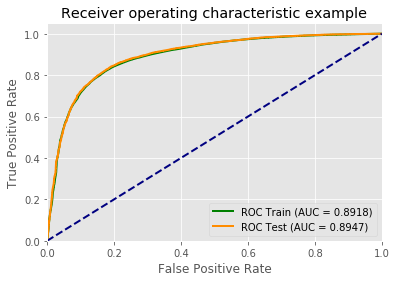

In [20]:
# Import logistic regression from sklearn
from sklearn.linear_model import LogisticRegression

# Initialize model by providing parameters
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
clf = LogisticRegression(C=1.0, penalty='l2')
# Fit a model by providing X and y from training set
clf.fit(X_train, y_train)

# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

#### 4.2 Random Forest

              train      test
metrics                      
AUC        0.935614  0.918443
Accuracy   0.854635  0.842468
Precision  0.857902  0.847286
Recall     0.865076  0.849911
f1-score   0.861474  0.848596


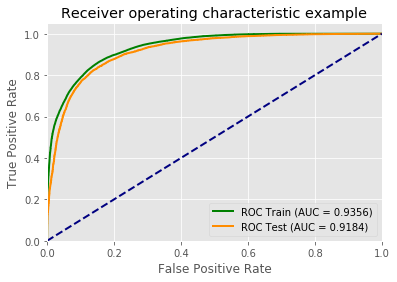

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Choose some parameter combinations to try
parameters = {'n_estimators': 50,
              'max_features': 'auto',
              'criterion': 'gini',
              'max_depth': 20,
              'min_samples_split': 2,
              'min_samples_leaf': 20,
              'random_state': 0,
              'n_jobs': -1
              }

clf = RandomForestClassifier(**parameters)

# Fit a model by providing X and y from training set
clf.fit(X_train, y_train)

# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

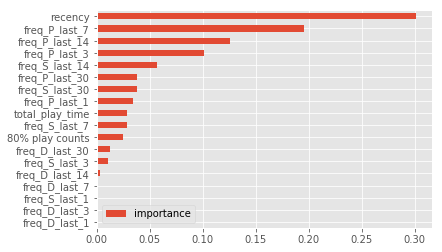

In [22]:
df_feature_importance = pd.DataFrame()
df_feature_importance['feature'] = selected_features
df_feature_importance['importance'] = clf.feature_importances_
df_feature_importance.sort_values('importance',inplace=True)

ax = df_feature_importance.plot.barh()
t = np.arange(len(df_feature_importance['feature']))
ax.set_yticks(t)
ax.set_yticklabels(df_feature_importance['feature'])
plt.show()

#### 4.3 Gradient Boosting Trees

              train      test
metrics                      
AUC        0.918978  0.915401
Accuracy   0.843644  0.837524
Precision  0.845980  0.840512
Recall     0.856732  0.848140
f1-score   0.851322  0.844309


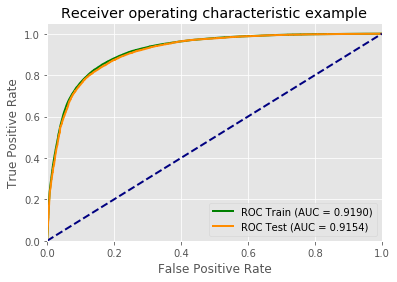

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

# Choose some parameter combinations to try
parameters = {
    'n_estimators': 50,
    'max_depth': 5,
    'learning_rate': 0.2,
    'subsample': 0.7,
    'max_features':0.8,
    'random_state': 42
}

clf = GradientBoostingClassifier(**parameters)

# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

#### 4.4 Neural Network

              train      test
metrics                      
AUC        0.739036  0.743111
Accuracy   0.668449  0.672825
Precision  0.617459  0.619304
Recall     0.960552  0.960670
f1-score   0.751708  0.753109


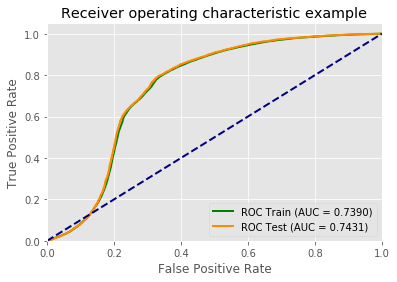

In [25]:
from sklearn.neural_network import MLPClassifier

# Choose some parameter combinations to try
parameters = {
    'solver':'adam', 
    'activation':'relu',
    'alpha':1e-5,
    'hidden_layer_sizes':(5,5), 
    'learning_rate':'adaptive',
    'random_state':1
    }
clf = MLPClassifier(**parameters)

# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

It appears that the Random Forest shows better performance. 

#### 4.5 Hyper Parameter Tuning For Random Forest: Grid Search

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [100], 
              'max_features': [4, 8], 
              'criterion': ['gini'],
              'max_depth': [20,25], 
              'min_samples_split': [5, 10],
              'min_samples_leaf': [2,5, 10],
              'n_jobs':[-1]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(roc_auc_score)

# Run the grid search
# read theory
grid_obj = GridSearchCV(clf, param_grid, cv=5, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

              train      test
metrics                      
AUC        0.947851  0.918741
Accuracy   0.868280  0.843312
Precision  0.870420  0.848710
Recall     0.878721  0.849838
f1-score   0.874551  0.849274


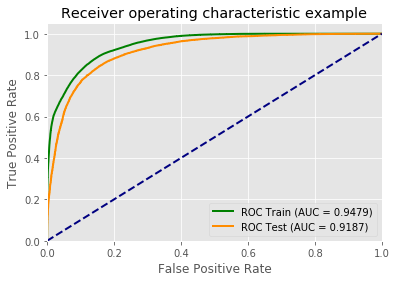

In [28]:
# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)